# Circuit

> SAX Circuits

In [1]:
from functools import partial

import sax
from sax.circuit import (
    _create_dag,
    _find_leaves,
    _find_root,
    _flat_circuit,
    _validate_models,
    draw_dag,
)

Let's start by creating a simple recursive netlist with gdsfactory.

:::{note}
We are using gdsfactory to create our netlist because it allows us to see the circuit we want to simulate and because we're striving to have a compatible netlist implementation in SAX.

However... gdsfactory is not a dependency of SAX. You can also define your circuits by hand (see [SAX Quick Start](../examples/01_quick_start.ipynb) or you can use another tool to programmatically construct your netlists.
:::

In [2]:
import gdsfactory as gf
from IPython.display import display
from gdsfactory.components import mzi


@gf.cell
def twomzi():
    c = gf.Component()

    # instances
    mzi1 = mzi(delta_length=10)
    mzi2 = mzi(delta_length=20)

    # references
    mzi1_ = c.add_ref(mzi1, name="mzi1")
    mzi2_ = c.add_ref(mzi2, name="mzi2")

    # connections
    mzi2_.connect("o1", mzi1_.ports["o2"])

    # ports
    c.add_port("o1", port=mzi1_.ports["o1"])
    c.add_port("o2", port=mzi2_.ports["o2"])
    return c

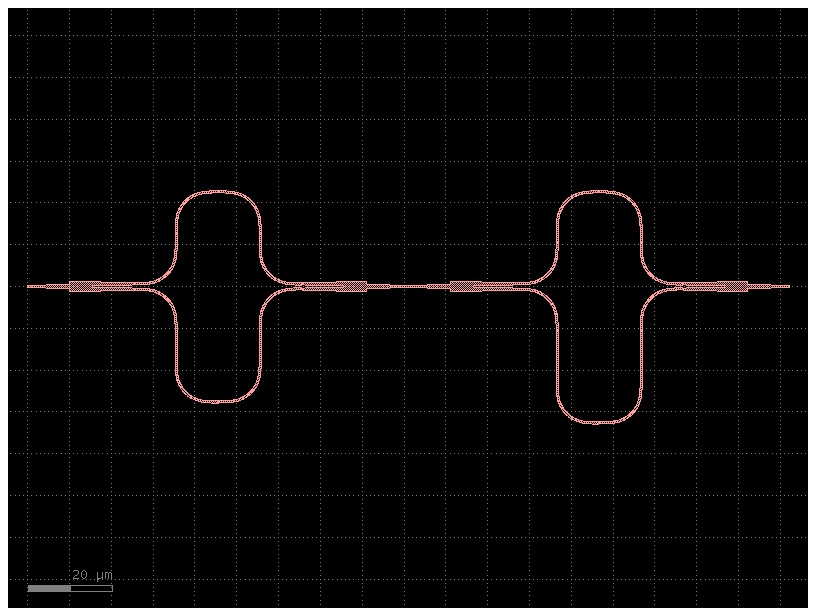

In [3]:
comp = twomzi()
comp

In [4]:
recnet = sax.RecursiveNetlist.parse_obj(comp.get_netlist(recursive=True))
mzi1_comp = recnet.root["twomzi"].instances["mzi1"].component
flatnet = recnet.root[mzi1_comp]

/tmp/ipykernel_3642/418843444.py:1: PydanticDeprecatedSince20: The `parse_obj` method is deprecated; use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  recnet = sax.RecursiveNetlist.parse_obj(comp.get_netlist(recursive=True))


To be able to model this device we'll need some SAX dummy models:

In [5]:
def bend_euler(
    angle=90.0,
    p=0.5,
    # cross_section="strip",
    # direction="ccw",
    # with_bbox=True,
    # with_arc_floorplan=True,
    # npoints=720,
):
    return sax.reciprocal({("o1", "o2"): 1.0})

In [6]:
def mmi1x2(
    width=0.5,
    width_taper=1.0,
    length_taper=10.0,
    length_mmi=5.5,
    width_mmi=2.5,
    gap_mmi=0.25,
    # cross_section= strip,
    # taper= {function= taper},
    # with_bbox= True,
):
    return sax.reciprocal(
        {
            ("o1", "o2"): 0.45**0.5,
            ("o1", "o3"): 0.45**0.5,
        }
    )

In [7]:
def mmi2x2(
    width=0.5,
    width_taper=1.0,
    length_taper=10.0,
    length_mmi=5.5,
    width_mmi=2.5,
    gap_mmi=0.25,
    # cross_section= strip,
    # taper= {function= taper},
    # with_bbox= True,
):
    return sax.reciprocal(
        {
            ("o1", "o3"): 0.45**0.5,
            ("o1", "o4"): 1j * 0.45**0.5,
            ("o2", "o3"): 1j * 0.45**0.5,
            ("o2", "o4"): 0.45**0.5,
        }
    )

In [8]:
def straight(
    length=0.01,
    # npoints=2,
    # with_bbox=True,
    # cross_section=...
):
    return sax.reciprocal({("o1", "o2"): 1.0})

In SAX, we usually aggregate the available models in a models dictionary:

In [9]:
models = {
    "straight": straight,
    "bend_euler": bend_euler,
    "mmi1x2": mmi1x2,
}

We can also create some dummy multimode models:

In [10]:
def bend_euler_mm(
    angle=90.0,
    p=0.5,
    # cross_section="strip",
    # direction="ccw",
    # with_bbox=True,
    # with_arc_floorplan=True,
    # npoints=720,
):
    return sax.reciprocal(
        {
            ("o1@TE", "o2@TE"): 0.9**0.5,
            # ('o1@TE', 'o2@TM'): 0.01**0.5,
            # ('o1@TM', 'o2@TE'): 0.01**0.5,
            ("o1@TM", "o2@TM"): 0.8**0.5,
        }
    )

In [11]:
def mmi1x2_mm(
    width=0.5,
    width_taper=1.0,
    length_taper=10.0,
    length_mmi=5.5,
    width_mmi=2.5,
    gap_mmi=0.25,
    # cross_section= strip,
    # taper= {function= taper},
    # with_bbox= True,
):
    return sax.reciprocal(
        {
            ("o1@TE", "o2@TE"): 0.45**0.5,
            ("o1@TE", "o3@TE"): 0.45**0.5,
            ("o1@TM", "o2@TM"): 0.41**0.5,
            ("o1@TM", "o3@TM"): 0.41**0.5,
            ("o1@TE", "o2@TM"): 0.01**0.5,
            ("o1@TM", "o2@TE"): 0.01**0.5,
            ("o1@TE", "o3@TM"): 0.02**0.5,
            ("o1@TM", "o3@TE"): 0.02**0.5,
        }
    )

In [12]:
def straight_mm(
    length=0.01,
    # npoints=2,
    # with_bbox=True,
    # cross_section=...
):
    return sax.reciprocal(
        {
            ("o1@TE", "o2@TE"): 1.0,
            ("o1@TM", "o2@TM"): 1.0,
        }
    )

In [13]:
models_mm = {
    "straight": straight_mm,
    "bend_euler": bend_euler_mm,
    "mmi1x2": mmi1x2_mm,
}

We can now represent our recursive netlist model as a Directed Acyclic Graph:

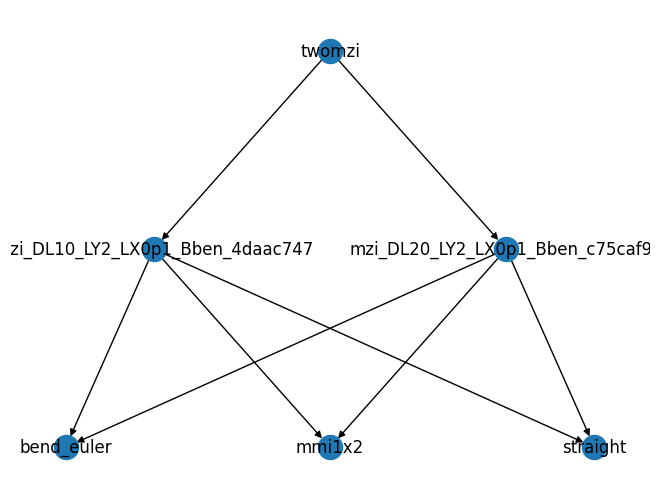

In [14]:
dag = _create_dag(recnet, models)
draw_dag(dag)

Note that the DAG depends on the models we supply. We could for example stub one of the sub-netlists by a pre-defined model:

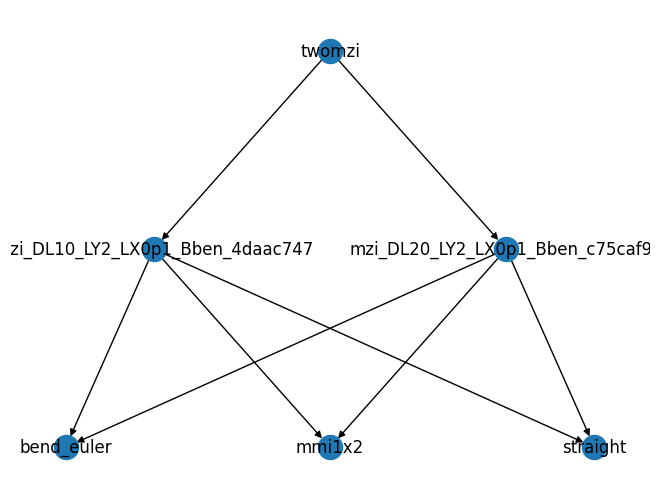

In [15]:
dag_ = _create_dag(recnet, {**models, "mzi_delta_length10": mmi2x2})
draw_dag(dag_, with_labels=True)

This is useful if we for example pre-calculated a certain model.

We can easily find the root of the DAG:

In [16]:
_find_root(dag)

['twomzi']

Similarly we can find the leaves:

In [17]:
_find_leaves(dag)

['bend_euler', 'mmi1x2', 'straight']

To be able to simulate the circuit, we need to supply a model for each of the leaves in the dependency DAG. Let's write a validator that checks this

In [18]:
models = _validate_models(models, dag)

We can now dow a bottom-up simulation. Since at the bottom of the DAG, our circuit is always flat (i.e. not hierarchical) we can implement a minimal `_flat_circuit` definition, which only needs to work on a flat (non-hierarchical circuit):

In [19]:
flatnet = recnet.root[mzi1_comp]
single_mzi = _flat_circuit(
    flatnet.instances,
    flatnet.connections,
    flatnet.ports,
    models,
    "default",
)
single_mzi()

(Array([[0. +0.j, 0.9+0.j],
        [0.9+0.j, 0. +0.j]], dtype=complex128),
 {'o1': 0, 'o2': 1})

The resulting circuit is just another SAX model (i.e. a python function) returing an SType:

In [20]:
?single_mzi

Let's 'execute' the circuit:

Note that we can also supply multimode models:

In [21]:
flatnet = recnet.root[mzi1_comp]
single_mzi = _flat_circuit(
    flatnet.instances,
    flatnet.connections,
    flatnet.ports,
    models_mm,
    "default",
)
single_mzi()

(Array([[0.        +0.j, 0.        +0.j, 0.7482    +0.j, 0.23011426+0.j],
        [0.        +0.j, 0.        +0.j, 0.23011426+0.j, 0.5491    +0.j],
        [0.7482    +0.j, 0.23011426+0.j, 0.        +0.j, 0.        +0.j],
        [0.23011426+0.j, 0.5491    +0.j, 0.        +0.j, 0.        +0.j]],      dtype=complex128),
 {'o1@TE': 0, 'o1@TM': 1, 'o2@TE': 2, 'o2@TM': 3})

Now that we can handle flat circuits the extension to hierarchical circuits is not so difficult:

single mode simulation:

In [22]:
double_mzi, info = sax.circuit(recnet, models, backend="default")
double_mzi()

/home/runner/work/sax/sax/.venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:5820: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)
/home/runner/work/sax/sax/.venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:5820: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)
/home/runner/work/sax/sax/.venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:5820: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)
/home/runner/work/sax/sax/.venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:5820: FutureWarning:

{('o1', 'o1'): Array(0.+0.j, dtype=complex128),
 ('o1', 'o2'): Array(0.81+0.j, dtype=complex128),
 ('o2', 'o1'): Array(0.81+0.j, dtype=complex128),
 ('o2', 'o2'): Array(0.+0.j, dtype=complex128)}

multi mode simulation:

In [23]:
double_mzi, info = sax.circuit(
    recnet, models_mm, backend="default", return_type="sdict"
)
double_mzi()

/home/runner/work/sax/sax/.venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:5820: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)
/home/runner/work/sax/sax/.venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:5820: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)
/home/runner/work/sax/sax/.venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:5820: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  return array(a, dtype=dtype, copy=bool(copy), order=order, device=device)
/home/runner/work/sax/sax/.venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:5820: FutureWarning:

{('o1@TE', 'o1@TE'): Array(0.+0.j, dtype=complex128),
 ('o1@TE', 'o1@TM'): Array(0.+0.j, dtype=complex128),
 ('o1@TE', 'o2@TE'): Array(0.61275581+0.j, dtype=complex128),
 ('o1@TE', 'o2@TM'): Array(0.29852723+0.j, dtype=complex128),
 ('o1@TM', 'o1@TE'): Array(0.+0.j, dtype=complex128),
 ('o1@TM', 'o1@TM'): Array(0.+0.j, dtype=complex128),
 ('o1@TM', 'o2@TE'): Array(0.29852723+0.j, dtype=complex128),
 ('o1@TM', 'o2@TM'): Array(0.35446338+0.j, dtype=complex128),
 ('o2@TE', 'o1@TE'): Array(0.61275581+0.j, dtype=complex128),
 ('o2@TE', 'o1@TM'): Array(0.29852723+0.j, dtype=complex128),
 ('o2@TE', 'o2@TE'): Array(0.+0.j, dtype=complex128),
 ('o2@TE', 'o2@TM'): Array(0.+0.j, dtype=complex128),
 ('o2@TM', 'o1@TE'): Array(0.29852723+0.j, dtype=complex128),
 ('o2@TM', 'o1@TM'): Array(0.35446338+0.j, dtype=complex128),
 ('o2@TM', 'o2@TE'): Array(0.+0.j, dtype=complex128),
 ('o2@TM', 'o2@TM'): Array(0.+0.j, dtype=complex128)}

sometimes it's useful to get the required circuit model names to be able to create the circuit:

In [24]:
sax.get_required_circuit_models(recnet, models)

['bend_euler', 'mmi1x2', 'straight']